# 5. LSTM BackTesting

To further enhance this project, Two Backtesting algorithms are tested to find the optimal strategies with max return and determine the number of buying and selling stocks for each day.


## Input Data

In [1]:
!pip install ta
!pip install pandas_ta

In [2]:
import math
import numpy as np
import pandas as pd
import ta
import pandas_ta as pta
#import blankly
import matplotlib.pyplot as plt
import seaborn as sns
import os
#os.chdir('/content/drive/MyDrive')
#!ls

import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
# read dataset
df = pd.read_csv('/content/drive/MyDrive/Database/AAPL.csv')

In [6]:
## Prepare datafram ##
#df.set_index('Date', inplace=True)
#df_AAPL = df.filter(['AAPL'],axis=1)
df = df.rename(columns={'Adj Close':'AAPL'})
df_AAPL = df[:].copy()
# relative strenth index
df_AAPL['RSI'] = pta.rsi(df_AAPL.AAPL, length=14)
#slow and fast moving average
df_AAPL['EMA_slow']=pta.ema (df_AAPL.AAPL, length=200)
df_AAPL['EMA_fast']=pta.ema(df_AAPL.AAPL, length=25)
#define Bollinger Bands
my_bbands = pta.bbands(df_AAPL.AAPL, length=14, std=2.0)
my_bbands[0:50]
df_AAPL=df_AAPL.join(my_bbands)
df_AAPL.dropna(inplace=True)
df_AAPL=df_AAPL.reset_index()
df_AAPL.isna().sum()
del df_AAPL['index']
df_AAPL


,Date,Open,High,Low,Close,AAPL,Volume,RSI,EMA_slow,EMA_fast,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0
0,2000-10-16,0.398438,0.415179,0.381696,0.383929,0.325878,820176000,27.116340,0.803111,0.525842,0.086144,0.398888,0.711632,156.807720,0.383274
1,2000-10-17,0.387277,0.391741,0.351563,0.359375,0.305036,601720000,25.960934,0.798155,0.508857,0.117003,0.367695,0.618386,136.358647,0.375029
2,2000-10-18,0.347098,0.376116,0.334821,0.359375,0.305036,834265600,25.960934,0.793248,0.493179,0.280361,0.331561,0.382761,30.884316,0.240969
3,2000-10-19,0.342076,0.353795,0.327009,0.338170,0.287038,1506724800,24.898351,0.788211,0.477322,0.279636,0.324186,0.368735,27.483902,0.083069
4,2000-10-20,0.340402,0.363839,0.338170,0.348214,0.295563,791263200,26.434265,0.783309,0.463340,0.279351,0.319043,0.358735,24.881714,0.204217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5775,2023-10-02,171.220001,174.300003,170.929993,173.750000,173.750000,52164500,44.066869,170.821708,176.433291,169.320638,174.309287,179.297936,5.723905,0.443944
5776,2023-10-03,172.259995,173.630005,170.820007,172.399994,172.399994,49594600,41.822090,170.837412,176.123037,169.094876,174.180000,179.265124,5.838930,0.324979
5777,2023-10-04,171.089996,174.210007,170.970001,173.660004,173.660004,53020300,44.655806,170.865498,175.933573,169.016239,174.031429,179.046618,5.763545,0.462970
5778,2023-10-05,173.789993,175.449997,172.679993,174.910004,174.910004,48527900,47.393342,170.905742,175.854837,169.014410,174.024287,179.034164,5.757676,0.588397


In [7]:
## Prepare the dataframe for LSTM: ##
# Use the previous 7 days data to predict next day price
df_AAPL_LSTM = df_AAPL.filter(['AAPL'],axis=1)

df_AAPL_full = df_AAPL[7:]

from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'AAPL(t-{i})'] = df['AAPL'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df_AAPL_LSTM, lookback)
shifted_df
shifted_df_as_np = shifted_df.to_numpy()

# scale the data between (-1, 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# mirror the data from AAPL(t-7) to AAPL，preparing for LSTM
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
# X.shape, y.shape
X = dc(np.flip(X, axis=1))
# X

# prepare for train and test dataset
split_index = int(len(X) * 0.95)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

# Add another dimention preparing for LSTM
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# transfer to pytorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

# In pytorch, use dataset to train models
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Also, use DataLoader to get batches
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break


torch.Size([16, 7, 1]) torch.Size([16, 1])


## Modelling

### LSTM Model

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# set num_stacked_layers = 1 as LSTM tends to overfit
# play around with hidden_size and num_stacked_layers
model = LSTM(1, 4, 1)
model.to(device)

def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad() #zero_grad
        loss.backward() # backward to calculate the gradient
        optimizer.step() # step towards the gradient

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): # not model update, no need caculate grad
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [9]:
learning_rate = 0.001
num_epochs = 50
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

loss_function = RMSELoss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.693
Batch 200, Loss: 0.159
Batch 300, Loss: 0.057

Val Loss: 0.217
***************************************************

Epoch: 2
Batch 100, Loss: 0.043
Batch 200, Loss: 0.035
Batch 300, Loss: 0.026

Val Loss: 0.114
***************************************************

Epoch: 3
Batch 100, Loss: 0.017
Batch 200, Loss: 0.014
Batch 300, Loss: 0.014

Val Loss: 0.064
***************************************************

Epoch: 4
Batch 100, Loss: 0.012
Batch 200, Loss: 0.012
Batch 300, Loss: 0.013

Val Loss: 0.052
***************************************************

Epoch: 5
Batch 100, Loss: 0.013
Batch 200, Loss: 0.012
Batch 300, Loss: 0.012

Val Loss: 0.050
***************************************************

Epoch: 6
Batch 100, Loss: 0.011
Batch 200, Loss: 0.012
Batch 300, Loss: 0.012

Val Loss: 0.052
***************************************************

Epoch: 7
Batch 100, Loss: 0.012
Batch 200, Loss: 0.011
Batch 300, Loss: 0.011

Val Loss: 0.047
*****************

The RMSE loss is 0.028 which has a remarkable 72% improvement in accuracy, comparint to 0.10052452620729452 losses trhough ARIMA.

## Plot the result

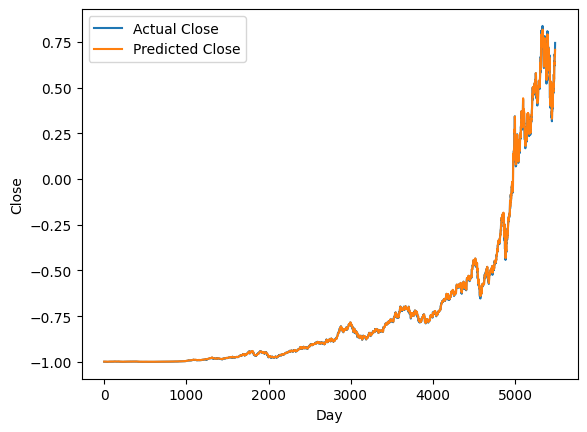

In [10]:
# Plot result
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy() # numpy used in CPU instead GPU

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [11]:
# scale back to the real value
train_predictions = predicted.flatten() # make sure its axis

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions # set first column to the prediction
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.3640052 ,   0.35719477,   0.35411081, ..., 164.32390488,
       167.29869361, 167.37697844])

In [12]:
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  0.28040519,   0.28040519,   0.28135141, ..., 168.24194323,
       167.49635362, 171.08506765])

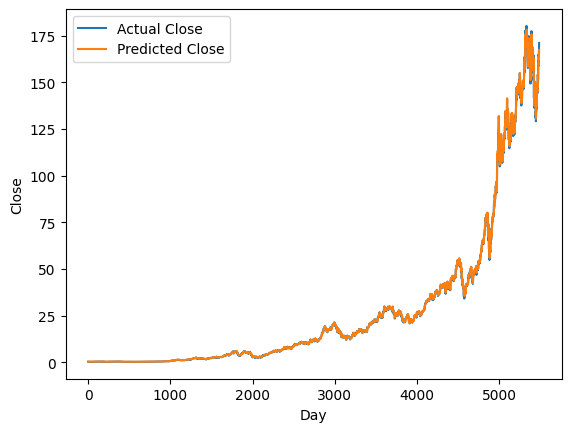

In [13]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [14]:
# df_AAPL.info()
# print('-----')
# df_AAPL_LSTM.info()
# print('-----')
# len(train_predictions)
# print('-----')
# len(shifted_df_as_np) # - first 7

## BackTesting Method one
Double EMA + Bollinger band



In [15]:
dfpl_1 = df_AAPL[:].copy()
dfpl_2 = dfpl_1[7:]
split_index = int(len(dfpl_2) * 0.95)
dfpl = dfpl_2[:split_index]
dfpl["AAPL"] = train_predictions
dfpl=dfpl.reset_index(drop = True)

dfpl= dfpl.loc[(dfpl['Close'] >= 100)].reset_index(drop = True)
#dfpl= dfpl.loc[(dfpl['Close'] >= 100)].set_index('Date')
#dfpl.index = pd.DatetimeIndex(df['Date'])
dfpl

<ipython-input-15-4b1e280e1a42>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpl["AAPL"] = train_predictions


,Date,Open,High,Low,Close,AAPL,Volume,RSI,EMA_slow,EMA_fast,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0
0,2020-07-31,102.885002,106.415001,100.824997,106.260002,94.692375,374336800,73.800085,74.240888,92.634670,88.314216,94.635358,100.956500,13.358944,1.255418
1,2020-08-03,108.199997,111.637497,107.892502,108.937500,103.438692,308151200,76.287944,74.564966,93.725141,86.553157,95.467363,104.381569,18.674876,1.136256
2,2020-08-04,109.132500,110.790001,108.387497,109.665001,106.947539,173071600,76.928977,74.892918,94.786598,85.433249,96.303569,107.173890,22.575115,1.016108
3,2020-08-05,109.377502,110.392502,108.897499,110.062500,108.082947,121776800,77.290233,75.221484,95.796385,84.911318,97.251833,109.592348,25.378473,0.931991
4,2020-08-06,110.404999,114.412498,109.797501,113.902496,108.561058,202428800,80.471466,75.584244,97.018113,84.219133,98.482682,112.746231,28.966614,0.962584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2022-08-08,166.369995,167.809998,164.199997,164.869995,164.582251,60276900,68.547083,151.852307,154.166391,147.778496,157.972023,168.165550,12.905483,0.790658
509,2022-08-09,164.020004,165.820007,163.250000,164.919998,164.334062,63135500,68.603496,151.972657,154.918777,148.794845,158.830666,168.866486,12.637132,0.754924
510,2022-08-10,167.679993,169.339996,166.899994,169.240005,164.323905,70170500,73.093178,152.134540,155.943636,149.064877,159.832259,170.599641,13.473353,0.890517
511,2022-08-11,170.059998,170.990005,168.190002,168.490005,167.298694,57149200,71.189821,152.287394,156.832306,150.148348,160.869942,171.591536,13.329518,0.809022


In [16]:
## SIGNAL ONE
## BUY / SELL signal based on Slow and fast MV ##
def addemasignal(df):
  emasignal = [0]*len (df)
  for i in range(0, len(df)):
    if df.EMA_slow[i]>df.EMA_fast[i]:
      emasignal[i]=2 # Buy
    elif df.EMA_slow[i]<df.EMA_fast[i]:
      emasignal[i]=1 # Sell
  df['EMASignal'] = emasignal

addemasignal(dfpl)

## Set Order Limit based on Bollinger band ##
def addorderslimit(df, percent):
  ordersignal=[0]*len(df)
  for i in range(1, len(df)):
    # less than lower bond, oversold; continue buy
    if df.AAPL[i]<=df['BBL_14_2.0'][i] and df. EMASignal[i]==2:
      ordersignal[i]=df.AAPL[i]-df.AAPL[i]*percent
    # more than upper bond, Overbought; continue sell
    elif df.AAPL[i]>=df['BBU_14_2.0'][i] and df.EMASignal[i]==1:
      ordersignal[i]=df.AAPL[i]+df.AAPL[i]*percent
  df['ordersignal']=ordersignal

addorderslimit(dfpl, 0.000)

In [17]:
## SIGNAL TWO
def support(df1, l, n1, n2): #n1 n2 before and after candle L
  for i in range(l-n1+1,l+1):
    if(df1. low[i]>df1.low[i-1]):
      return 0
  for i in range (l+1,l+n2+1) :
    if(df1.low[i]<df1.low[i-1]):
      return 0
  return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
  for i in range (l-n1+1, l+1):
    if(df1. high[i]<df1.high[i-1]):
      return 0
  for i in range(l+1,l+n2+1) :
    if(df1.high[i]>df1.high[i-1]):
      return 0
  return 1

In [18]:
!pip uninstall bokeh
!pip install bokeh==3.2.1

Found existing installation: bokeh 3.2.1
Uninstalling bokeh-3.2.1:
  Would remove:
    /usr/local/bin/bokeh
    /usr/local/lib/python3.10/dist-packages/bokeh-3.2.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/bokeh/*
Proceed (Y/n)? Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 105, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 680, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 375, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 415, in _allowed_to_p

In [19]:
!pip install backtesting

In [20]:
from backtesting import Strategy
from backtesting import Backtest

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [21]:
def SIGNAL():
  return dfpl.ordersignal
dfpl

,Date,Open,High,Low,Close,AAPL,Volume,RSI,EMA_slow,EMA_fast,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0,EMASignal,ordersignal
0,2020-07-31,102.885002,106.415001,100.824997,106.260002,94.692375,374336800,73.800085,74.240888,92.634670,88.314216,94.635358,100.956500,13.358944,1.255418,1,0.0
1,2020-08-03,108.199997,111.637497,107.892502,108.937500,103.438692,308151200,76.287944,74.564966,93.725141,86.553157,95.467363,104.381569,18.674876,1.136256,1,0.0
2,2020-08-04,109.132500,110.790001,108.387497,109.665001,106.947539,173071600,76.928977,74.892918,94.786598,85.433249,96.303569,107.173890,22.575115,1.016108,1,0.0
3,2020-08-05,109.377502,110.392502,108.897499,110.062500,108.082947,121776800,77.290233,75.221484,95.796385,84.911318,97.251833,109.592348,25.378473,0.931991,1,0.0
4,2020-08-06,110.404999,114.412498,109.797501,113.902496,108.561058,202428800,80.471466,75.584244,97.018113,84.219133,98.482682,112.746231,28.966614,0.962584,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2022-08-08,166.369995,167.809998,164.199997,164.869995,164.582251,60276900,68.547083,151.852307,154.166391,147.778496,157.972023,168.165550,12.905483,0.790658,1,0.0
509,2022-08-09,164.020004,165.820007,163.250000,164.919998,164.334062,63135500,68.603496,151.972657,154.918777,148.794845,158.830666,168.866486,12.637132,0.754924,1,0.0
510,2022-08-10,167.679993,169.339996,166.899994,169.240005,164.323905,70170500,73.093178,152.134540,155.943636,149.064877,159.832259,170.599641,13.473353,0.890517,1,0.0
511,2022-08-11,170.059998,170.990005,168.190002,168.490005,167.298694,57149200,71.189821,152.287394,156.832306,150.148348,160.869942,171.591536,13.329518,0.809022,1,0.0


In [22]:
class MyStrat(Strategy):
  initsize = 0.5
  mysize = initsize
  def init(self):
    super().init()
    self.signal = self.I(SIGNAL)

  def next (self):
    super().next()
    TPSLRatio= 2 # stop loss ratio
    perc = 0.005
    if len(self.trades)>0:
      if self.data.index[-1]-self.trades[-1].entry_time>=10:
        self.trades[-1].close()
      if self.trades[-1].is_long and self.data.RSI[-1]>=75:
        self.trades[-1].close()
      elif self.trades[-1].is_short and self.data.RSI[-1]<=25:
        self.trades[-1].close()

    # continue buy
    if self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==2:
      sl1 = min(self.data.Low[-1],self.data.Low[-2])*(1-perc) # STOP LOSS
      tpl = self.data.Close[-1]+(self.data.Close[-1]-sl1)*TPSLRatio # Target PROFIT
      self.buy(sl=sl1, tp=tpl, size=self.mysize)

    # continue sell
    elif self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==1:
      sl1 = sl1 = max(self.data.High[-1],self.data.High[-2])*(1+perc)
      tpl = self.data.Close[-1]-(sl1- self.data.Close[-1])*TPSLRatio
      self.sell(sl=sl1, tp=tpl,size=self.mysize)

In [23]:
bt = Backtest(dfpl, MyStrat, cash=10000, commission=.002)
stat = bt.run()
stat

<ipython-input-23-843140e37b83>:1: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(dfpl, MyStrat, cash=10000, commission=.002)


Start                                     0.0
End                                     512.0
Duration                                512.0
Exposure Time [%]                    3.703704
Equity Final [$]                 10090.482804
Equity Peak [$]                  10389.168037
Return [%]                           0.904828
Buy & Hold Return [%]                61.96123
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -4.29494
Avg. Drawdown [%]                   -1.428064
Max. Drawdown Duration                  414.0
Avg. Drawdown Duration                  105.5
# Trades                                  6.0
Win Rate [%]                        33.333333
Best Trade [%]                       7.860269
Worst Trade [%]                     -5.482124
Avg. Trade [%]                    

## Backtesing Method Two
A Triple EMA/Stochastic RSI(%K line and %D line )/ATR Trading Strategy

In [24]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover


In [25]:
class TradePro(Strategy):

  def init(self):
    close = self.data.Close
    high = self.data. High
    low = self.data.Low
    self.stoch_k = self.I(ta.momentum.stochrsi_k, pd.Series(close)) # %K line to measure price momentum
    self.stoch_d = self.I(ta.momentum. stochrsi_d, pd.Series (close)) # %D line
    self.EMA_8 = self.I(ta.trend.ema_indicator, pd.Series (close), window=8)
    self.EMA_14 = self.I(ta.trend.ema_indicator, pd.Series (close), window=14)
    self.EMA_50 = self.I(ta.trend.ema_indicator, pd.Series (close), window=50)
    self.atr = self.I(ta.volatility.average_true_range, pd.Series(high), pd.Series (low), pd.Series (close)) # Volatility Indicator

  def next(self):
    price = self.data.Close
    if (crossover(self.stoch_k, self.stoch_d) and price > self.EMA_8 and self. EMA_8 > self.EMA_14 and self.EMA_14 > self.EMA_50):
      sl = price - self.atr * 3
      tp = price + self.atr * 2
      self.buy(sl = sl, tp = tp)

In [28]:
bt = Backtest(dfpl, TradePro, cash= 10000, commission=.002)

<ipython-input-28-d3b677c2e073>:1: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(dfpl, TradePro, cash= 10000, commission=.002)


In [29]:
bt.run()

Start                                     0.0
End                                     512.0
Duration                                512.0
Exposure Time [%]                   32.553606
Equity Final [$]                 14276.752922
Equity Peak [$]                  15885.045389
Return [%]                          42.767529
Buy & Hold Return [%]                61.96123
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -19.81417
Avg. Drawdown [%]                   -3.736184
Max. Drawdown Duration                  153.0
Avg. Drawdown Duration              23.153846
# Trades                                 16.0
Win Rate [%]                            81.25
Best Trade [%]                       8.218739
Worst Trade [%]                     -9.183624
Avg. Trade [%]                    